# Week 2 Quiz

In [4]:
import os
import cv2
import skimage
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

## 1)
What is the mean radius (in pixels) of the blobs from the image test_blob_varying.png?

C:\Users\s183921\AppData\Local\Temp/ipykernel_6684/288129363.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I = io.imread(os.path.join('..', 'solutions', 'Data', 'week2', 'test_blob_varying.png')).astype(np.float)


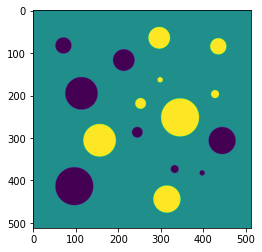

In [15]:
I = io.imread(os.path.join('..', 'solutions', 'Data', 'week2', 'test_blob_varying.png')).astype(np.float)
plt.imshow(I)

In [16]:
# Detecting blobs
def getGaussDerivative(t):
    '''
    Computes kernels of Gaussian and its derivatives.
    Parameters
    ----------
    t : float
        Vairance - t.

    Returns
    -------
    g : numpy array
        Gaussian.
    dg : numpy array
        First order derivative of Gaussian.
    ddg : numpy array
        Second order derivative of Gaussian
    dddg : numpy array
        Third order derivative of Gaussian.

    '''

    kSize = 5
    s = np.sqrt(t)
    x = np.arange(int(-np.ceil(s*kSize)), int(np.ceil(s*kSize))+1)
    x = np.reshape(x,(-1,1))
    g = np.exp(-x**2/(2*t))
    g = g/np.sum(g)
    dg = -x/t*g
    ddg = -g/t - x/t*dg
    dddg = -2*dg/t - x/t*ddg
    return g, dg, ddg, dddg

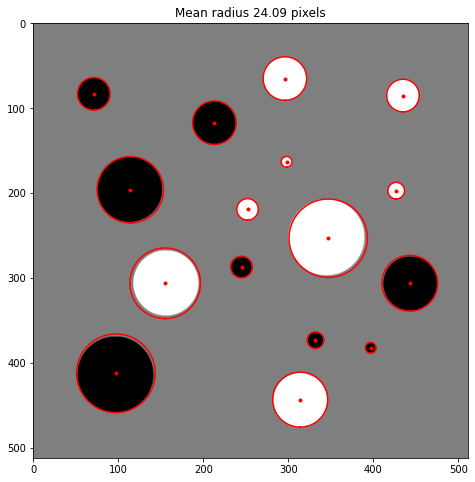

In [17]:
t = 4
g, dg, ddg, dddg = getGaussDerivative(t)

r,c = I.shape
n = 400
L_blob_vol = np.zeros((r,c,n))
tStep = np.zeros(n)

Lg = I
for i in range(0,n):
    tStep[i] = t*i
    L_blob_vol[:,:,i] = tStep[i]*(cv2.filter2D(cv2.filter2D(Lg, -1, g), -1, ddg.T) + 
        cv2.filter2D(cv2.filter2D(Lg, -1, ddg), -1, g.T))
    Lg = cv2.filter2D(cv2.filter2D(Lg, -1, g), -1, g.T)


#%% find maxima in scale-space
thres = 40.0
coord_pos = skimage.feature.peak_local_max(L_blob_vol, threshold_abs = thres)
coord_neg = skimage.feature.peak_local_max(-L_blob_vol, threshold_abs = thres)
coord = np.r_[coord_pos,coord_neg]

# Show circles
theta = np.arange(0, 2*np.pi, step=np.pi/100)
theta = np.append(theta, 0)
circ = np.array((np.cos(theta),np.sin(theta)))
n = coord.shape[0]
m = circ.shape[1]


#%%
scale = tStep[coord[:,2]]
mean_radius = np.mean(np.sqrt(2*scale))
circ_y = np.sqrt(2*scale)*np.reshape(circ[0,:],(1,-1)).T*np.ones((1,n)) + np.ones((m,1))*np.reshape(coord[:,0],(-1,1)).T
circ_x = np.sqrt(2*scale)*np.reshape(circ[1,:],(1,-1)).T*np.ones((1,n)) + np.ones((m,1))*np.reshape(coord[:,1],(-1,1)).T


fig, ax = plt.subplots(1,1,figsize=(8,8),sharex=True,sharey=True)
ax.imshow(I, cmap='gray')
ax.plot(coord[:,1], coord[:,0], '.r')
ax.set_title(f'Mean radius {mean_radius:0.2f} pixels')
plt.plot(circ_x, circ_y, 'r')

## 2)
What is the number of fibers detected by the blob detector in the image CT_lab_high_res.png?

C:\Users\s183921\AppData\Local\Temp/ipykernel_6684/2021021954.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = skimage.io.imread(os.path.join('..', 'solutions', 'Data', 'week2', 'CT_lab_high_res.png')).astype(np.float)


Detected 201 fibers with simple method. See better method below


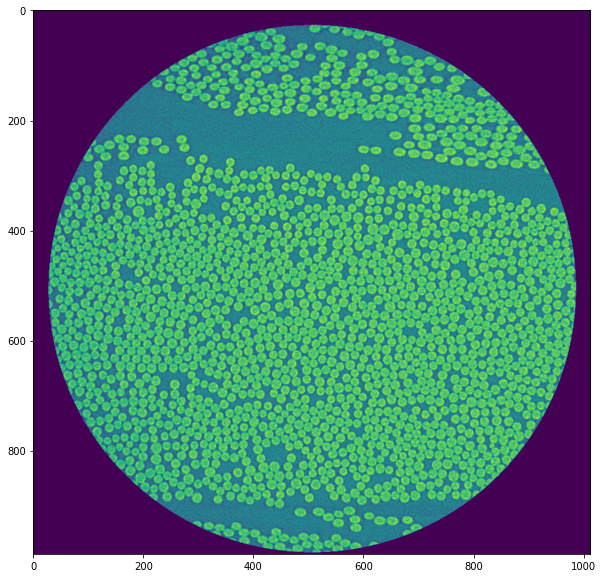

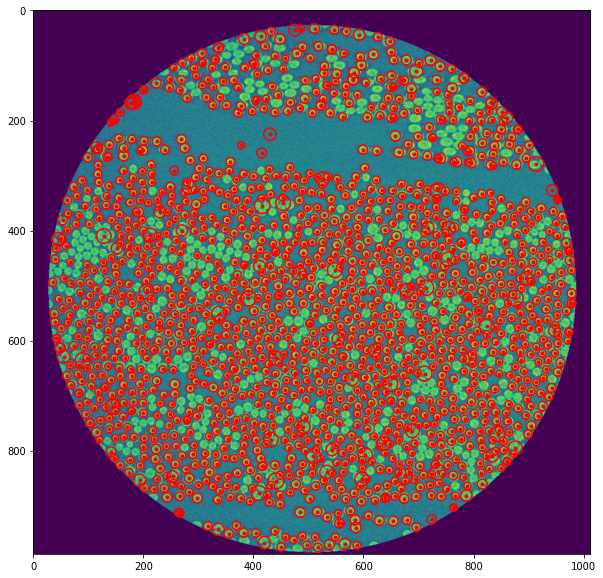

In [18]:
# Detecting blobs in real data (scale space)

# diameter interval and steps
d = np.arange(10, 24.5, step = 0.4)
tStep = np.sqrt(0.5)*((d/2)**2) # convert to scale

# read image and take out a small part
im = skimage.io.imread(os.path.join('..', 'solutions', 'Data', 'week2', 'CT_lab_high_res.png')).astype(np.float)
# im = im[200:500,200:500]

fig, ax = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)
ax.imshow(im)

#%% Compute scale space

r,c = im.shape
n = d.shape[0]
L_blob_vol = np.zeros((r,c,n))

for i in range(0,n):
    g, dg, ddg, dddg = getGaussDerivative(tStep[i])
    L_blob_vol[:,:,i] = tStep[i]*(cv2.filter2D(cv2.filter2D(im,-1,g),-1,ddg.T) + 
                                  cv2.filter2D(cv2.filter2D(im,-1,ddg),-1,g.T))


#%% Find maxima in scale space

thres = 30
coord = skimage.feature.peak_local_max(-L_blob_vol, threshold_abs = thres)

# Show circles
def getCircles(coord, scale):
    '''
    Comptue circle coordinages

    Parameters
    ----------
    coord : numpy array
        2D array of coordinates.
    scale : numpy array
        scale of individual blob (t).

    Returns
    -------
    circ_x : numpy array
        x coordinates of circle. Each column is one circle.
    circ_y : numpy array
        y coordinates of circle. Each column is one circle.

    '''
    theta = np.arange(0, 2*np.pi, step=np.pi/100)
    theta = np.append(theta, 0)
    circ = np.array((np.cos(theta),np.sin(theta)))
    n = coord.shape[0]
    m = circ.shape[1]
    circ_y = np.sqrt(2*scale)*circ[[0],:].T*np.ones((1,n)) + np.ones((m,1))*coord[:,[0]].T
    circ_x = np.sqrt(2*scale)*circ[[1],:].T*np.ones((1,n)) + np.ones((m,1))*coord[:,[1]].T
    return circ_x, circ_y

scale = tStep[coord[:,2]]
circ_x, circ_y = getCircles(coord[:,0:2], scale)
fig, ax = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)
ax.imshow(im)
plt.plot(coord[:,1], coord[:,0], '.r')
plt.plot(circ_x, circ_y, 'r')
print(f'Detected {len(circ_x)} fibers with simple method. See better method below')

## 3)
What is the mean radius (in pixels) of the blobs from the image CT_lab_high_res.png?

In [19]:
def detectFibers(im, diameterLimit, stepSize, tCenter, thresMagnitude):
    '''
    Detects fibers in images by finding maxima of Gaussian smoothed image

    Parameters
    ----------
    im : numpy array
        Image.
    diameterLimit : numpy array
        2 x 1 vector of limits of diameters of the fibers (in pixels).
    stepSize : float
        step size in pixels.
    tCenter : float
        Scale of the Gaussian for center detection.
    thresMagnitude : float
        Threshold on blob magnitude.

    Returns
    -------
    coord : TYPE
        DESCRIPTION.
    scale : TYPE
        DESCRIPTION.

    '''
    
    radiusLimit = diameterLimit/2
    radiusSteps = np.arange(radiusLimit[0], radiusLimit[1]+0.1, stepSize)
    tStep = radiusSteps**2/2
    
    r,c = im.shape
    n = tStep.shape[0]
    L_blob_vol = np.zeros((r,c,n))
    for i in range(0,n):
        g, dg, ddg, dddg = getGaussDerivative(tStep[i])
        L_blob_vol[:,:,i] = tStep[i]*(cv2.filter2D(cv2.filter2D(im,-1,g),-1,ddg.T) + 
                                      cv2.filter2D(cv2.filter2D(im,-1,ddg),-1,g.T))
    # Detect fibre centers
    g, dg, ddg, dddg = getGaussDerivative(tCenter)
    Lg = cv2.filter2D(cv2.filter2D(im, -1, g), -1, g.T)
    
    coord = skimage.feature.peak_local_max(Lg, threshold_abs = thresMagnitude)
    
    # Find coordinates and size (scale) of fibres
    magnitudeIm = np.min(L_blob_vol, axis = 2)
    scaleIm = np.argmin(L_blob_vol, axis = 2)
    scales = scaleIm[coord[:,0], coord[:,1]]
    magnitudes = -magnitudeIm[coord[:,0], coord[:,1]]
    idx = np.where(magnitudes > thresMagnitude)
    coord = coord[idx[0],:]
    scale = tStep[scales[idx[0]]]
    return coord, scale

 ...]

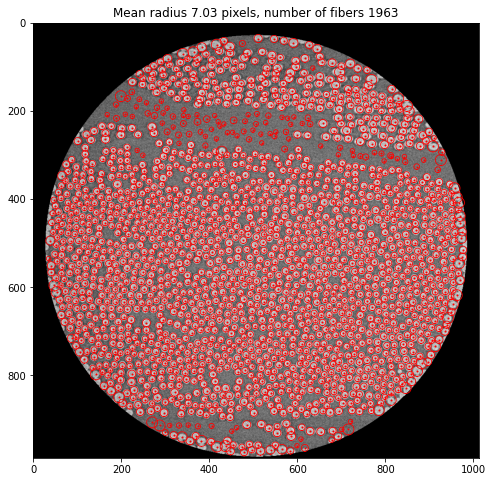

In [20]:
# Radius limit
diameterLimit = np.array([10,25])
stepSize = 0.1

# Parameter for Gaussian to detect center point
tCenter = 20

# Parameter for finding maxima over Laplacian in scale-space
thresMagnitude = 12

# Detect fibres
coord, scale = detectFibers(im, diameterLimit, stepSize, tCenter, thresMagnitude)

mean_radius = np.mean(np.sqrt(2*scale))
#%%
# Plot detected fibres
fig, ax = plt.subplots(1,1,figsize=(8,8),sharex=True,sharey=True)
ax.imshow(im, cmap='gray')
ax.plot(coord[:,1], coord[:,0], 'r.', markersize = 2)
ax.set_title(f'Mean radius {mean_radius:0.2f} pixels, number of fibers {scale.shape[0]}')
circ_x, circ_y = getCircles(coord, scale)
ax.plot(circ_x, circ_y, 'r', linewidth=0.8)